# Header

DKE가 뭔지 여기서 차근차근 알아보도록 하자. 
paper가 준 data를 받아서 어떻게 만들었는지 알아보자.

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

### The paper is reproducible!

이렇게 하니까 Fig 1과 동일한 그림을 그릴 수 있어여ㅛ!
```python
dataset = xr.open_dataset('dataset_paper/pangu1000.nc')
u = dataset['u'].var(dim="ens")
v = dataset['v'].var(dim="ens")
dke = u + v

weights = np.cos(np.deg2rad(dke.lat))
weights.name = "weights"
dke_weighted = dke.weighted(weights)
dke_weighted = dke_weighted.mean(dim=("lat", "lon"))
'
# plot in y-axis log scale
dke_weighted.plot()
```

In [2]:
dataset = xr.open_dataset("dataset_paper/pangu1000/pangu1000.nc")
u = dataset['u'].var(dim="ens")
v = dataset['v'].var(dim="ens")
dke = u + v # (73, 721, 1440)

# calculate the weighted mean
weights = np.cos(np.deg2rad(dke.lat))
weights.name = "weights"
dke_weighted = dke.weighted(weights)
dke_weighted = dke_weighted.mean(dim=("lat", "lon"))

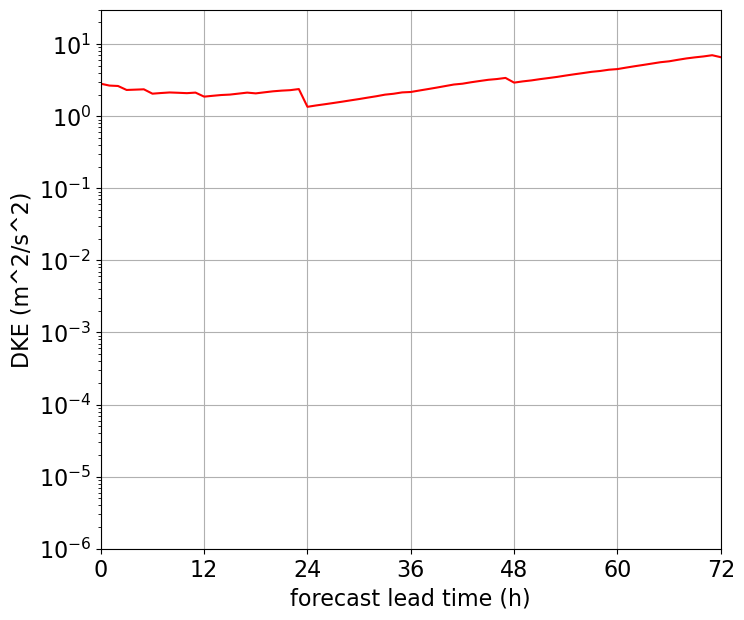

In [3]:
# plot dke in log-scale y axis

# increase the figure font size
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8, 7))
plt.plot(np.arange(0, 73, 1), dke_weighted, color="red")
plt.yscale("log")

# x axis: 0 ~ 72hr, hourly
plt.xticks(np.arange(0, 73, 12))
plt.xlim(0, 72)
plt.xlabel("forecast lead time (h)")
plt.ylim(10**-6, 30)
plt.ylabel("DKE (m^2/s^2)")
plt.grid()
plt.savefig("dke_weighted.png") 

```bash
 cdo remapbil,n360 pangu1000_ensavg.nc tmp.nc
 cdo uv2dv,linear tmp.nc pangu1000_dv.nc
 rm -f tmp.nc
 ```

In [4]:
# testing o1's answer
dataset2 = xr.open_dataset("dataset_paper/pangu1000/pangu1000_dv.nc")
dataset2

<xarray.Dataset>
Dimensions:  (time: 73, plev: 1, nsp: 259560, nc2: 2)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-26 2021-06-26T01:00:00 ... 2021-06-29
  * plev     (plev) float64 300.0
Dimensions without coordinates: nsp, nc2
Data variables:
    sd       (time, plev, nsp, nc2) float32 ...
    svo      (time, plev, nsp, nc2) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Dec 05 15:14:32 2024: cdo uv2dv,linear tmp.nc pangu1000...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [5]:

u = dataset['u']
print(u.shape)
v = dataset['v']

dataset_ensavg = dataset.mean(dim="ens")
u_mean = dataset_ensavg['u']
print(u_mean.shape)
v_mean = dataset_ensavg['v']
u.time[24]

(5, 73, 1, 721, 1440)
(73, 1, 721, 1440)


<xarray.DataArray 'time' ()>
array('2021-06-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-06-27

In [6]:

u_hat = np.fft.rfft(u, axis=u.dims.index('lon'))
v_hat = np.fft.rfft(v, axis=v.dims.index('lon'))

u_mean_hat = np.fft.rfft(u_mean, axis=u_mean.dims.index('lon'))
v_mean_hat = np.fft.rfft(v_mean, axis=v_mean.dims.index('lon'))

# shape of x_hat = (5, 73, 721, 1440); (ens, time, lat, lon)
# shape of x_mean_hat = (73, 721, 1440); (time, lat, lon)
print(u_hat.shape)
print(u_mean_hat.shape)

(5, 73, 1, 721, 721)
(73, 1, 721, 721)


$$e_i = \frac{1}{2}\left(\lvert\hat{u}\rvert^2 + \lvert\hat{v}\rvert^2\right)$$
$$e_{mean} = \frac{1}{N}\sum_i e_i(k, \phi)$$

In [7]:
e_i = 0.5*(np.abs(u_hat)**2 + np.abs(v_hat)**2) # (5, 73, 721, 1440) = (ens, time, lat, lon)
e_mean = np.mean(e_i, axis=3) # (73, 721, 1440) = (time, lat, lon)
e_mean.shape

(5, 73, 1, 721)

$$\overline{\tilde{e}}=\frac{1}{2}\left(\lvert\langle\tilde{u}_i(k, \phi)\rangle\rvert^2+\lvert\langle\tilde{v}_i(k, \phi)\rangle\rvert^2\right)$$

In [8]:
e_mean_field = 0.5*(np.abs(u_mean_hat)**2 + np.abs(v_mean_hat)**2) # (73, 721, 1440)
e_mean_field.shape

(73, 1, 721, 721)

$$\Delta \tilde{e}(k, \phi) = \frac{N}{N-1}(\langle e_i(k, \phi)\rangle - \overline{e}(k, \phi))$$

In [9]:
N = u.shape[3] # 5
print(N)
DKE = (N/(N-1))*(e_mean - e_mean_field) # (73, 721, 1440)
DKE.shape

721


ValueError: operands could not be broadcast together with shapes (5,73,1,721) (73,1,721,721) 

In [ ]:
k_dim = DKE.shape[2]
wavenumbers = np.arange(1, k_dim+1)
DKE_spectra = DKE * np.expand_dims(wavenumbers, axis=(0,1)) 

phi = np.deg2rad(dataset['lat'])
weights = np.cos(phi)
weights = weights / weights.sum()

weights_3d = np.expand_dims(weights, axis=(0,-1))

DKE_global = (DKE * weights_3d).mean(axis=1)

# DKE_k = DKE.mean(axis=1)
# nlon = u.sizes['lon']
# wavenumbers = np.arange(nlon)
# DKE_k = wavenumbers * DKE_k

# By Myself

In [10]:
dataset = xr.open_dataset("dataset_paper/pangu1000/pangu1000.nc").sel(plev=300)
dataset

<xarray.Dataset>
Dimensions:  (ens: 5, time: 73, lat: 721, lon: 1440, nsp: 259560, nc2: 2)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-26 2021-06-26T01:00:00 ... 2021-06-29
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
    plev     float64 300.0
  * ens      (ens) int64 1 2 3 4 5
Dimensions without coordinates: nsp, nc2
Data variables:
    u        (ens, time, lat, lon) float32 ...
    v        (ens, time, lat, lon) float32 ...
    geopot   (ens, time, lat, lon) float32 ...
    vo       (ens, time, nsp, nc2) float32 ...
    div      (ens, time, nsp, nc2) float32 ...

In [11]:
u = dataset['u']
v = dataset['v']

print(u.shape) # (5, 73, 721, 1440) = (ens, time, lat, lon)

n = np.sqrt(u.shape[u.dims.index("lon")])

tilde_u = np.fft.fft(u,axis=u.dims.index("lon"))/n
tilde_v = np.fft.fft(v,axis=u.dims.index("lon"))/n

tilde_u.shape # (5, 73, 721, 721) = (ens, time, lat, wave)

(5, 73, 721, 1440)


(5, 73, 721, 1440)

### KE Spectra
$$
\tilde{e}(k)= \frac{k}{2}(\langle \lvert \tilde u_i\rvert^2\rangle + \langle \lvert \tilde v_i\rvert^2\rangle)
$$

In [12]:
KE_spectra = 0.5 * (tilde_u * np.conj(tilde_u)).mean(axis=0) + 0.5 * (tilde_v * np.conj(tilde_v)).mean(axis=0)

KE_spectra.shape

(73, 721, 1440)

### DKE Spectra

$$\begin{align}
\Delta\tilde e  &= k(\text{var}(\tilde u) + \text{var}(\tilde v) )\\
&= k\frac{N}{N-1}(\underbrace{\langle \lvert \tilde u_i\rvert^2\rangle + \langle \lvert \tilde v_i\rvert^2\rangle}_{\text{ensemble mean of the KE spectral densities}} - \underbrace{(\langle \lvert \tilde u_i\rvert\rangle^2 + \langle \lvert \tilde v_i\rvert\rangle^2)}_{\text{KE spectral density of the ensemble mean}})
\end{align}$$

In [13]:
var_tilde_u = tilde_u.var(axis=u.dims.index("ens"), ddof=1)
var_tilde_v = tilde_v.var(axis=v.dims.index("ens"), ddof=1)

DKE_spectra_1 = var_tilde_u + var_tilde_v

var_tilde_u.shape

(73, 721, 1440)

In [14]:
u_2_mean = ((tilde_u * np.conj(tilde_u))).mean(axis=u.dims.index("ens"))
v_2_mean = ((tilde_v * np.conj(tilde_v))).mean(axis=v.dims.index("ens"))

u_mean_2 = tilde_u.mean(axis=u.dims.index("ens")) * np.conj(tilde_u.mean(axis=u.dims.index("ens")))
v_mean_2 = tilde_v.mean(axis=v.dims.index("ens")) * np.conj(tilde_v.mean(axis=u.dims.index("ens")))

N = u.shape[u.dims.index("ens")]
bias = N/(N-1)

DKE_spectra_2 = bias * (u_2_mean + v_2_mean - u_mean_2 - v_mean_2)
DKE_spectra_2.shape

(73, 721, 1440)

In [15]:
# weight by cos(lat)

spectra = DKE_spectra_2
print(spectra.shape)
phi = np.deg2rad(dataset['lat'])
weight = np.cos(phi)

k = ((np.arange(spectra.shape[2])+1) * 2 * np.pi * 6317)/spectra.shape[2]
map = np.outer(weight, k)

spectra = spectra * map
# k = np.arange(spectra.shape[2]) + 1
# spectra = spectra * np.arange(spectra.shape[2])

weights = weight / weight.sum()

weights_3d = np.expand_dims(weights, axis=(0 ,-1))
print(weights_3d.shape)

spectra = spectra * weights_3d
print(spectra.shape)

DKE_global = spectra.mean(axis=1)

DKE_global.shape

(73, 721, 1440)
(1, 721, 1)
(73, 721, 1440)


(73, 1440)

### Plot

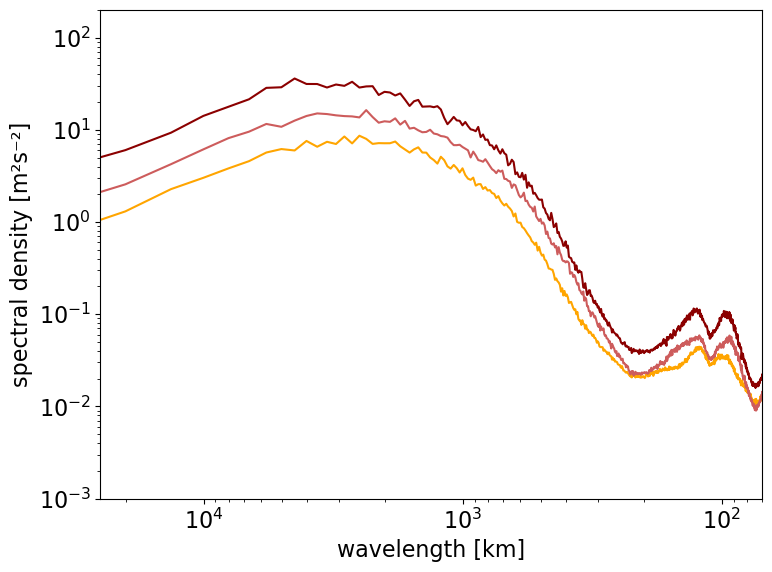

In [26]:

import matplotlib.pyplot as plt

data = DKE_global[72]*0.5

# Initialize figure with research-quality specifications
plt.figure(figsize=(8, 6))

# Calculate wavelength array (assuming spherical harmonics)
n360_circumference = 40075  # Earth's circumference in km
wavenumbers = np.arange(1, len(data)+1)
wavelengths = n360_circumference / wavenumbers  # Convert to wavelengths in km

# Create loglog plot with reversed x-axis
# plt.loglog(10**log_k, DKE_log_defined, 'k-', linewidth=1.5, label='Total KE')
dark_red = (139/255, 0/255, 0/255)
medium_red = (205/255, 92/255, 92/255)
orange = (255/255, 165/255, 0/255)
plt.loglog(wavelengths, DKE_global[24]*0.5, linewidth=1.5, color=orange)
plt.loglog(wavelengths, DKE_global[48]*0.5, linewidth=1.5, color=medium_red)
plt.loglog(wavelengths, DKE_global[72]*0.5, linewidth=1.5,color=dark_red)

# Configure axes
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Set labels with units
plt.xlabel('wavelength [km]')
plt.ylabel('spectral density [m²s⁻²]')
# plt.title('Pangu-100%')

# Set axis limits to match reference plot
plt.xlim(70, 2.5*10**4)
plt.gca().invert_xaxis()  # Reverse x-axis direction
plt.ylim(10**-3, 2*10**2)

plt.tight_layout()
plt.savefig("dke_failed spectra.png")

---
# From Vorticity and Divergence

In [17]:
a = np.array([1, 3, 5])

cos = np.array([1, 2, 3, 4])

map = np.outer(a, cos)

original = np.array([[[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 9]], [[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 9]]])
result = original * map
print(result)
print(result.shape)

b = np.array([3, 2, 1])
b = np.expand_dims(b, axis=(0, -1))

(result * b).mean(axis=1)

[[[  1   6  15  28]
  [  6  24  54  96]
  [ 15  50 105 180]]

 [[  1   6  15  28]
  [  6  24  54  96]
  [ 15  50 105 180]]]
(2, 3, 4)


array([[ 10.        ,  38.66666667,  86.        , 152.        ],
       [ 10.        ,  38.66666667,  86.        , 152.        ]])

In [18]:
ds = xr.open_dataset("dataset_paper/pangu1000/pangu1000.nc")
ds

<xarray.Dataset>
Dimensions:  (ens: 5, time: 73, plev: 1, lat: 721, lon: 1440, nsp: 259560,
              nc2: 2)
Coordinates:
  * time     (time) datetime64[ns] 2021-06-26 2021-06-26T01:00:00 ... 2021-06-29
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * plev     (plev) float64 300.0
  * ens      (ens) int64 1 2 3 4 5
Dimensions without coordinates: nsp, nc2
Data variables:
    u        (ens, time, plev, lat, lon) float32 ...
    v        (ens, time, plev, lat, lon) float32 ...
    geopot   (ens, time, plev, lat, lon) float32 ...
    vo       (ens, time, plev, nsp, nc2) float32 ...
    div      (ens, time, plev, nsp, nc2) float32 ...

ValueError: x and y must have same first dimension, but have shapes (1440,) and (73, 1, 721, 1440)

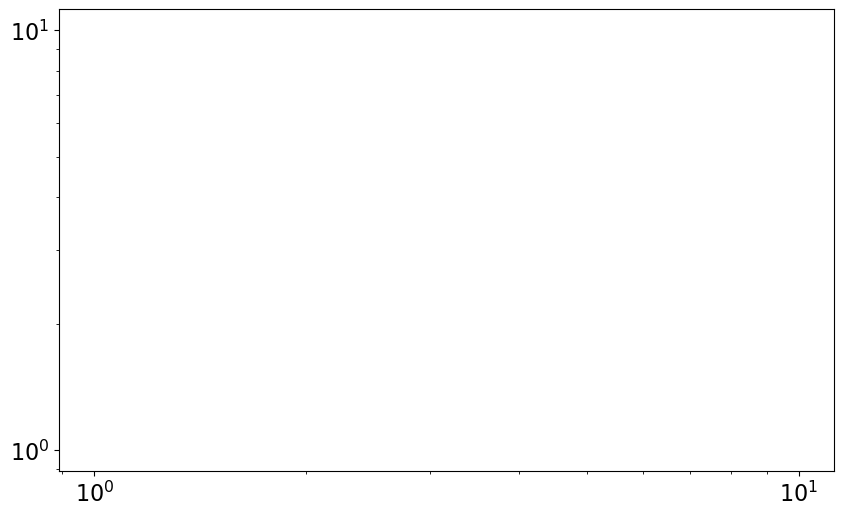

In [19]:

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.loglog(wavenumbers, dke, 'k-', label='DKE')
plt.grid(True)
plt.xlabel('Wavenumber')
plt.ylabel('DKE [m²/s²]')
plt.title('Difference Kinetic Energy Spectrum at 300 hPa')
plt.legend()
plt.show()

# Parseval

In [145]:
# dke=dke.mean(axis=1)
np.sqrt( 42.66283115000347)

6.5316790452381746

In [148]:
parseval_ok = check_parseval_dke(dke, spectra, 24, 720)
if parseval_ok:
    print("Parseval's theorem holds for the given indices!")
else:
    print("Parseval's theorem does not hold within the given tolerance.")

Parseval's theorem does not hold for the given indices.
Ratio of right/left: 2.269757067111428e-30
Ratio of right/left: 4.4057578429423505e+29
Parseval's theorem does not hold within the given tolerance.


In [66]:
# 사용 예시:
# time_idx, lat_idx, ens_idx = 0, 100, 0 가정

# ens time lat wave => time lat wave ens
parseval_ok = check_parseval_original(u, tilde_u, 2, 24, 100)
if parseval_ok:
    print("Parseval's theorem holds for the given indices!")
else:
    print("Parseval's theorem does not hold within the given tolerance.")


Parseval's theorem holds for the given indices!


In [65]:
import numpy as np

# ens time lat wave 
def check_parseval_original(u, tilde_u, ens_idx, time_idx, lat_idx, atol=1e-12):
    """
    Parameters
    ----------
    u : ndarray
        원래 도메인 데이터, shape (time, lat, lon, ens)
    tilde_u : ndarray
        FFT 결과 데이터, shape (time, lat, wavenumber, ens) 
        tilde_u = np.fft.fft(u, axis=2)
    time_idx : int
        확인할 time 인덱스
    lat_idx : int
        확인할 lat 인덱스
    ens_idx : int
        확인할 ens 인덱스
    atol : float, optional
        부동소수 비교를 위한 절대 오차 허용범위 (기본값 1e-12)
        
    Returns
    -------
    bool
        True면 Parseval's theorem을 만족한다고 볼 수 있음
    """
    # 해당 인덱스에서 lon축(u)과 wavenumber축(tilde_u)을 추출
    u_slice = u[ens_idx, time_idx, lat_idx, :]          # shape: (lon,)
    tilde_u_slice = tilde_u[ens_idx, time_idx, lat_idx, :]  # shape: (wavenumber,)
    
    N = u_slice.shape[0]  # lon 개수(=FFT 길이)
    
    # 좌변: 실제 도메인에서의 에너지
    left_side = np.sum(np.abs(u_slice)**2)
    # 우변: 파수 도메인에서의 파워 합의 평균
    right_side = (1.0/N)*np.sum(tilde_u_slice * np.conj(tilde_u_slice))
    
    # Parseval's theorem에 따르면 두 값은 같아야 함
    # 부동소수 연산 오차로 인해 정확히 같지 않을 수 있으므로 np.isclose로 비교
    return np.isclose(left_side, right_side, atol=atol)



In [147]:

def check_parseval_dke(u, tilde_u, time_idx, lat_idx, atol=1e-12):
    """
    Parameters
    ----------
    u : ndarray
        원래 도메인 데이터, shape (time, lat, lon)
    tilde_u : ndarray
        FFT 결과 데이터, shape (time, lat, wavenumber) 
        tilde_u = np.fft.fft(u, axis=2)
    time_idx : int
        확인할 time 인덱스
    lat_idx : int
        확인할 lat 인덱스
    ens_idx : int
        확인할 ens 인덱스
    atol : float, optional
        부동소수 비교를 위한 절대 오차 허용범위 (기본값 1e-12)
        
    Returns
    -------
    bool
        True면 Parseval's theorem을 만족한다고 볼 수 있음
    """
    # 해당 인덱스에서 lon축(u)과 wavenumber축(tilde_u)을 추출
    u_slice = u[time_idx, lat_idx, :]          # shape: (lon,)
    tilde_u_slice = tilde_u[time_idx, lat_idx, :]  # shape: (wavenumber,)
    
    N = u_slice.shape[0]  # lon 개수(=FFT 길이)
    
    # 좌변: 실제 도메인에서의 에너지
    left_side = np.sum(np.abs(u_slice)**2)
    # 우변: 파수 도메인에서의 파워 합의 평균
    right_side = np.sum(tilde_u_slice * np.conj(tilde_u_slice)).real
    # Parseval's theorem에 따르면 두 값은 같아야 함
    # 부동소수 연산 오차로 인해 정확히 같지 않을 수 있으므로 np.isclose로 비교
    if np.isclose(left_side, right_side, atol=atol):
        return True
    else:
        # 만약 Parseval's theorem을 만족하지 않는다면, 어느 정도의 차이가 있는지 출력
        print(f"Parseval's theorem does not hold for the given indices.")

        # 차이를 출력하기 위해 두 값의 비율을 계산
        ratio =  right_side / left_side
        print(f"Ratio of right/left: {ratio.values}")
        
        ratio =  left_side / right_side
        print(f"Ratio of right/left: {ratio.values}")
        return False

In [ ]:
t=np.arange(1025)*np.pi/128
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq[:5], sp[:5])
plt.legend(['real', 'imag'])
plt.show()
plt.plot(t, np.sin(t))
plt.show()

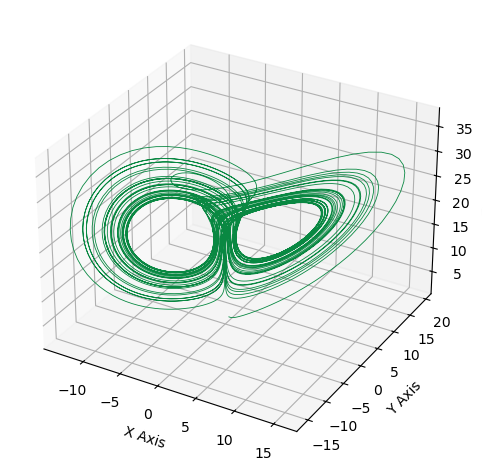

In [156]:
import matplotlib.pyplot as plt
import numpy as np

def lorenz(xyz, *, s=12, r=20, b=1.0):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.6, color='#098842')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
# ax.set_title("Lorenz Attractor")
plt.tight_layout()
plt.savefig("lorenz")

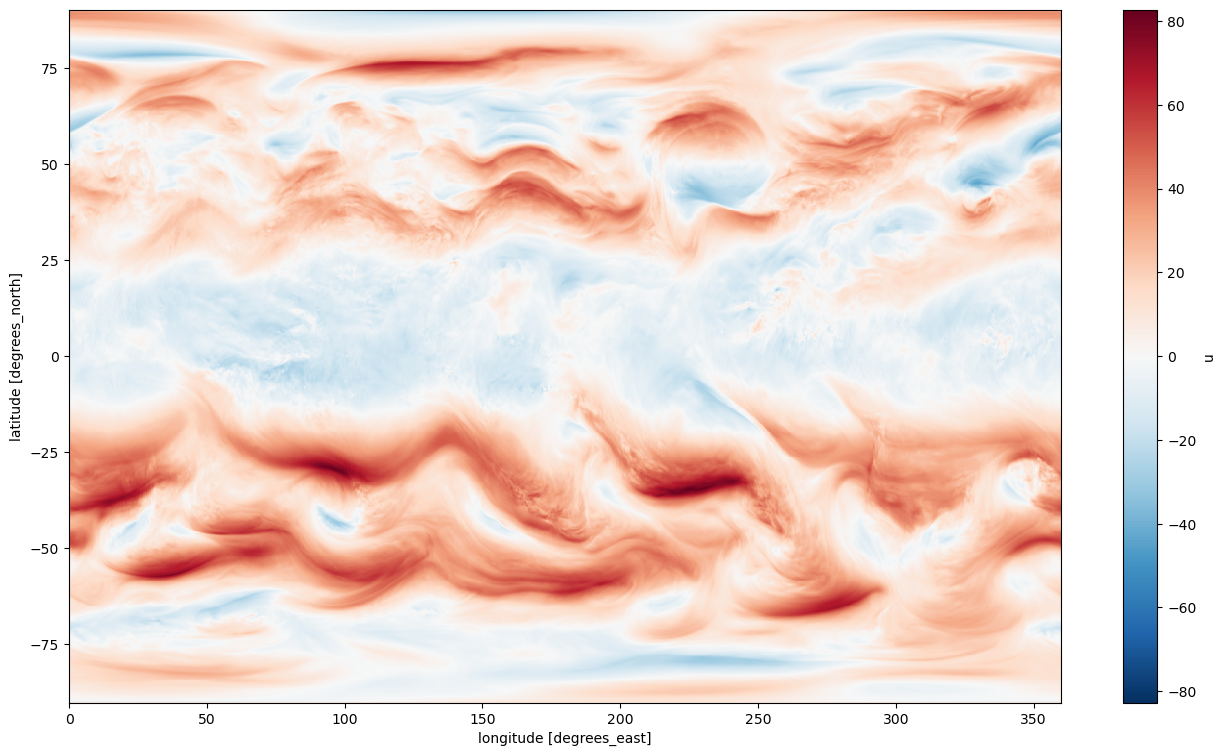

In [169]:
plt.figure(figsize=(16, 9))
data = dataset["u"].isel(ens=0, time=0)

# Plot the data
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# draw the border, land sea mask    
data.plot()
plt.title("")
plt.savefig("data")


In [194]:
np.arange(spectra.shape[2]) + 1

# numpy array from 1440 to 1
np.arange(1440, 0, -1)

array([1440, 1439, 1438, ...,    3,    2,    1])